In [1]:
# import statements
import numpy as np
import xarray as xr
import glob
import matplotlib.pyplot as plt
import PolarTestingTrainingSplit_CV
from matplotlib.colors import LinearSegmentedColormap

# Get names of models in which we are testing on
path_to_data = '/home/disk/pna2/aodhan/CMIP6/historical_monthly_tas_google/trendmap/*_TrendMaps.nc'
ModelNames = [i[68:-23] for i in glob.glob(path_to_data)]

# Get observational data
observational_trends = glob.glob('/home/disk/p/aodhan/SurfaceTrendLearing/PolarTASNDJFM/TASObsTrends/*NDJFM.npy')
observational_trend_maps = [np.load(observational_trends[i]) for i in range(0,len(observational_trends))]
latitudes = np.linspace(-88.75,88.75,72)
weights = np.cos(np.deg2rad(latitudes)) # these will be used to weight predictors
observational_trend_maps_weighted = np.multiply(observational_trend_maps, weights[np.newaxis,:,np.newaxis])
observational_trend_maps_reshaped = np.reshape(observational_trend_maps_weighted, (3, 72*144))

# Create Custom Color Map
colors = np.array([(22,98,248), (48,141,250), (71,172,251), (100,201,252), (129,222,253),(162,240,254), (215,249,253), (255,255,255), 
                   (255,255,255), (255,249,217), (247,236,155), (254,221,128), (254,202,100), (255,173,71), (252,142,42), (255,101,15)])/255
custom_cmap = LinearSegmentedColormap.from_list('cmap', colors)

# Do CV train-test-split 
TrainingPredictorData, TrainingTargetData, TestingPredictorData, TestingTargetData, TestingTotalTrend = PolarTestingTrainingSplit_CV.training_testing_split(path_to_data)

In [4]:
np.save('/home/disk/p/aodhan/SurfaceTrendLearing/PolarTASNDJFM/TestingTotalTrend.npy', TestingTotalTrend)

In [2]:
from sklearn.cross_decomposition import PLSRegression
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras import datasets, layers, models, optimizers


# iterate over all CV folds (there should be eqaul number of CV folds as models)
NameValidatationPredictions = []
gistemp_predictions = []
era5_predictions = []
hadcrut_predictions = []
stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, min_delta=4e-5, restore_best_weights=True)

for model_idx in range(0, len(ModelNames)):
    
    # reshape predictor data
    TrainingTargetDataShape = np.shape(TrainingTargetData[model_idx])
    TestinTargetDataShape = np.shape(TestingTargetData[model_idx])
    TrainingPredictorTimePeriod = np.reshape(TrainingPredictorData[model_idx], (int(len(TrainingPredictorData[model_idx])/26), 26, 72*144))
    TrainingTargetTimePeriod = np.reshape(TrainingTargetData[model_idx], (int(len(TrainingPredictorData[model_idx])/26), 26, 2, 3))
    
    X_train = TrainingPredictorTimePeriod[:,:,:]
    X_train = np.reshape(X_train, (len(X_train)*26,72*144))
    Y_train = TrainingTargetTimePeriod[:,:,:,:]
    Y_train = np.reshape(Y_train, (len(Y_train)*26,2,3))
    Y_train = Y_train[:,:,0]#[:,1]
    
    X_val = TrainingPredictorTimePeriod[:,-1,:]
    Y_val = TrainingTargetTimePeriod[:,-1,:,:]
    Y_val = Y_val[:,:,0]#[:,1]


    X_test = TestingPredictorData[model_idx]
    Y_test = TestingTargetData[model_idx]
    Y_test = Y_test[:,:,0]#[:,1]

    # scale all data
    t = MinMaxScaler()
    t.fit(X_train)
    X_train_scaled = t.transform(X_train)
    X_train_map = np.reshape(X_train_scaled, (len(X_train_scaled), 72,144,1))
    X_val_scaled = t.transform(X_val)
    X_val_map = np.reshape(X_val_scaled, (len(X_val_scaled), 72,144,1))
    X_test_scaled = t.transform(X_test)
    X_test_map = np.reshape(X_test_scaled, (len(X_test_scaled), 72,144,1))

    # Model Design
    pls = PLSRegression(n_components=6)
    pls.fit(X_train_scaled, Y_train)

    # Predict using trained model and find residuals
    Y_pred_train_pls = pls.predict(X_train_scaled)
    Y_pred_vals_pls = pls.predict(X_val_scaled)
    residuals = Y_train - Y_pred_train_pls
    resdiual_Y_vals = Y_val - Y_pred_vals_pls
    
    # create CNN
    cnn = Sequential()
    cnn.add(layers.Conv2D(128, 3, activation='relu',  input_shape=(72, 144, 1)))
    cnn.add(layers.MaxPooling2D(3))
    cnn.add(layers.Dropout(.3))
    cnn.add(layers.Flatten())
    cnn.add(layers.Dense(2))
    cnn.compile(loss="mse", optimizer=optimizers.Adam(learning_rate=1e-4))
    cnn.fit(X_train_map, residuals, epochs=2, verbose=1, callbacks=[stop_early], shuffle='True')
    cnn.save("/home/disk/p/aodhan/SurfaceTrendLearing/PolarTASNDJFM/output/Polar60N90NStackedPLS_C2_CNN_F128_K3_DO30_MP3_epoch2{modelname}.h5".format(modelname=ModelNames[model_idx]))

    # find predictions based on both models
    Y_pred_test_pls = pls.predict(X_test_scaled)
    Y_pred_cnn = cnn.predict(X_test_map)
    Y_pred = Y_pred_test_pls + Y_pred_cnn
    # Apply trained model to observations
    #Y_pred_Gistemp = MLmodel.predict(observational_trend_maps_reshaped[0].reshape(1, -1))
    #Y_pred_ERA5 = MLmodel.predict(observational_trend_maps_reshaped[1].reshape(1, -1))
    #Y_pred_HadCrut = MLmodel.predict(observational_trend_maps_reshaped[2].reshape(1, -1))
    
    # Save output for plotting
    NameValidatationPredictions.append([ModelNames[model_idx], Y_test, Y_pred])
    
    print(ModelNames[model_idx])
    print(stats.pearsonr(Y_test[:,0], Y_pred[:,0]))
    print(np.nanmean(np.square((Y_test[:,0] - Y_pred[:,0]))))
    print(np.nanmean(np.square((Y_test[:,1] - Y_pred[:,1]))))


2023-02-13 13:32:15.857131: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-13 13:32:44.678243: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-13 13:32:44.711105: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Epoch 1/2
187/187 [==============================] - 41s 214ms/step - loss: 0.0146
Epoch 2/2
1/1 [==============================] - 0s 91ms/step
IPSL_CM6A_LR
(0.9688992092128221, 9.49565703384572e-20)
0.0688351696854824
0.0450871094140811
Epoch 1/2
204/204 [==============================] - 43s 211ms/step - loss: 0.0150
Epoch 2/2
1/1 [==============================] - 0s 48ms/step
GISS_E2_1_G
(0.9089369543378846, 4.22552965183774e-05)
0.007291660341789062
0.005694145658881211
Epoch 1/2
173/173 [==============================] - 37s 210ms/step - loss: 0.0163
Epoch 2/2
2/2 [==============================] - 0s 13ms/step
MIROC6
(0.9338969987737319, 4.4381579134099217e-23)
0.005853955490230262
0.005740191920381534
Epoch 1/2
205/205 [==============================] - 45s 217ms/step - loss: 0.0152
Epoch 2/2
1/1 [==============================] - 0s 251ms/step
MRI_ESM2_0
(0.9553591056640658, 1.6460863000923258e-05)
0.006908686897836217
0.0054867189681856565
Epoch 1/2
204/204 [================

/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must 

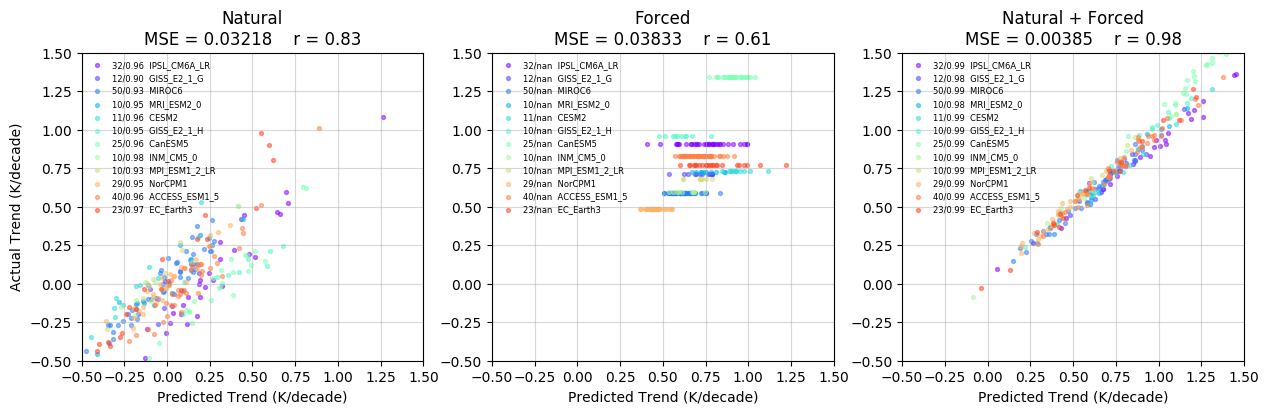

In [6]:
# Sc  d CONV2d(128,3,64,2,32,2 maxpooling(3), dense(2)
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
import matplotlib.cm as cm

####################################################################################
colors = cm.rainbow(np.linspace(0, 1, 13))
NatValAndPred = []
ForValAndPred = []
TotValAndPred = []
for model_idx in range(len(NameValidatationPredictions)):
    modelName = NameValidatationPredictions[model_idx][0]    
    ValidationData = NameValidatationPredictions[model_idx][1]
    PredictedData = NameValidatationPredictions[model_idx][2]
    TotalData = TestingTotalTrend[model_idx]
    N_ensembles = len(PredictedData)
    r_values = []

    for predictant_idx in range(3):
        axs_obj = axs[predictant_idx]

        # Natural Trend
        if predictant_idx == 0:
            val = ValidationData[:,0]
            pred = PredictedData[:,0]
            NatValAndPred.append([val, pred])
            axs_obj.set_ylabel('Actual Trend (K/decade)')

        # Forced Trend
        elif predictant_idx == 1:
            val = ValidationData[:,1]
            pred = PredictedData[:,1]
            ForValAndPred.append([val, pred])
        
        # Total Trend
        elif predictant_idx == 2:
            val = TotalData
            pred = PredictedData[:,0] + PredictedData[:,1]
            TotValAndPred.append([val, pred])

        #Plotting
        r = stats.pearsonr(val, pred)[0]
        label_id = str(N_ensembles) + '/' + str(r)[:4] + ' ' + ' ' + modelName
        
        axs_obj.scatter(pred, val, label=label_id, color=colors[model_idx], s=8, alpha=0.5)
        axs_obj.legend(loc=0, prop={'size': 6}, frameon=False)
        axs_obj.set_ylim(-0.5,1.5)
        axs_obj.set_xlim(-0.5,1.5)
        axs_obj.set_xlabel('Predicted Trend (K/decade)')
        axs_obj.grid(alpha=0.5)

# Give scores across all models and ensemble members
NatValAndPred = np.array(NatValAndPred)
ForValAndPred = np.array(ForValAndPred)
TotValAndPred = np.array(TotValAndPred)
AllModelAllEnsemble = [NatValAndPred, ForValAndPred, TotValAndPred]
titles = ['Natural', 'Forced', 'Natural + Forced']
for i in range(3):
    axs_obj = axs[i]
    val_pred_data = AllModelAllEnsemble[i]
    vals = list(np.concatenate(val_pred_data[:,0]).flat)
    preds = list(np.concatenate(val_pred_data[:,1]).flat)
    allsimulation_r = stats.pearsonr(vals, preds)[0]
    avg_deviation = np.nanmean(np.square((np.array(vals) - np.array(preds))))
    axs_obj.set_title(titles[i] + '\nMSE = ' + str(avg_deviation)[:7]+ '    r = ' + str(allsimulation_r)[:4])